In [1]:
from sklearn.cluster import KMeans
from keras.datasets import mnist
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical



In [2]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


C:\Users\MR.Mohebbian\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


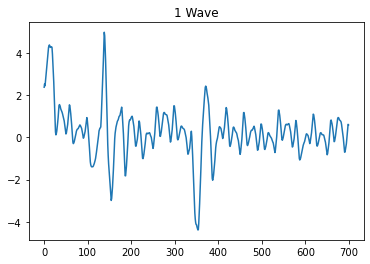

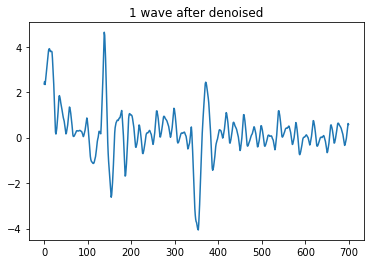

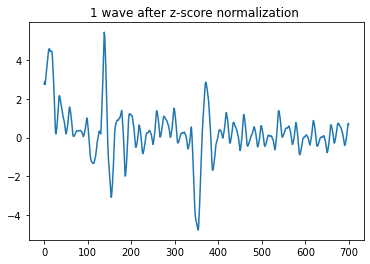

In [3]:
import scipy.io as sio
from scipy import signal
path = "E:\Workspaces\DopplerFHR\Data\\ninfea-non-invasive-multimodal-foetal-ecg-doppler-dataset-for-antenatal-cardiology-research-1.0.0\\dataSave.mat"
window_size = 180
maximum_counting = 10000

AllSignals = list()
mat_contents = sio.loadmat(path)
for i in range(24):
    AllSignals.append(mat_contents['dataSave'][0,i])
AllSignals=np.array(AllSignals)
# Records
finalBeats=[]
for r in range(24):
    signals=AllSignals[r][:,0]
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(str(r) + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(str(r) + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(str(r) + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    beates=[]
    for beatNumber in range(1000):
        beates.append(signals[beatNumber*250:beatNumber*250+250])
    beates=np.array(beates)
 
    signals = signal.resample(beates, 360,axis=1)
    finalBeats.append(signals)
finalBeats=np.asarray(finalBeats)

In [20]:
finalBeats.shape

(24, 1000, 360)

In [4]:
path = "./Data/mitbih_database/"
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

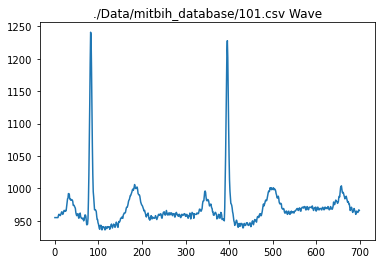

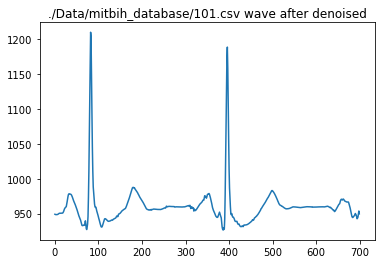

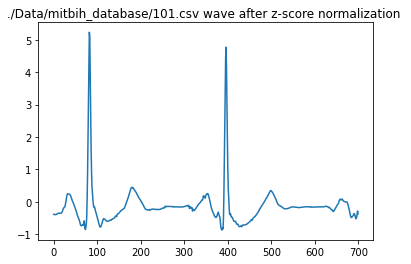

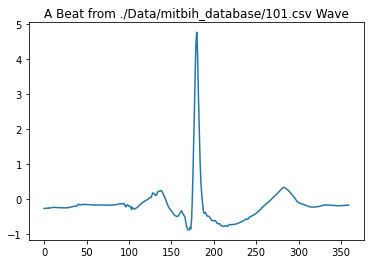

In [5]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

In [6]:
X_train_df = pd.DataFrame(np.append(X, np.expand_dims(y,axis=1),axis=1))
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [7]:
train, test = train_test_split(X_train_df, test_size=0.10,shuffle=True)
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
# train_y=target_train
# test_y=target_test
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)

In [17]:
len(target_test[target_test==0])
len(target_test)

2500

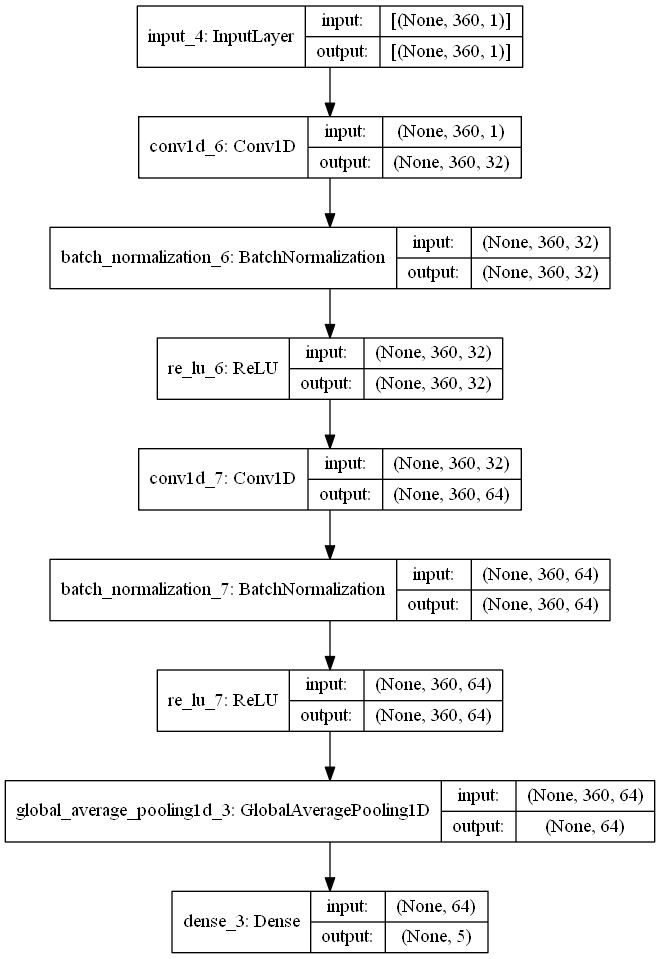

In [53]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

def make_model(input_shape,num_classes):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    embed = keras.layers.GlobalAveragePooling1D()(conv2)
    # embed=keras.backend.expand_dims(embed,2)
    # print(embed.shape)
    # conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(embed)
    # conv3 = keras.layers.BatchNormalization()(conv3)
    # conv3 = keras.layers.ReLU()(conv3)
    
    # conv4 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same")(conv3)
    # conv4 = keras.layers.BatchNormalization()(conv4)
    # conv4 = keras.layers.ReLU()(conv4)
    
    # gap = keras.layers.GlobalAveragePooling1D()(conv4)
    
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(embed)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=test_x.shape[1:],num_classes=5)
keras.utils.plot_model(model, show_shapes=True)

In [58]:
epochs = 10
batch_size = 8

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.7, patience=20, min_lr=0.001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="nadam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)
history = model.fit(
    train_x,
    train_y,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/10
2250/2250 [==============================] - 11s 5ms/step - loss: 0.6856 - categorical_accuracy: 0.7943 - val_loss: 1.0158 - val_categorical_accuracy: 0.5796
Epoch 2/10
2250/2250 [==============================] - 10s 4ms/step - loss: 0.6897 - categorical_accuracy: 0.7965 - val_loss: 0.9331 - val_categorical_accuracy: 0.6769
Epoch 3/10
2250/2250 [==============================] - 10s 4ms/step - loss: 0.6607 - categorical_accuracy: 0.8048 - val_loss: 1.1840 - val_categorical_accuracy: 0.5211
Epoch 4/10
2250/2250 [==============================] - 10s 4ms/step - loss: 0.6490 - categorical_accuracy: 0.8067 - val_loss: 0.7438 - val_categorical_accuracy: 0.7691
Epoch 5/10
2250/2250 [==============================] - 10s 4ms/step - loss: 0.6042 - categorical_accuracy: 0.8285 - val_loss: 0.8062 - val_categorical_accuracy: 0.7227
Epoch 6/10
2250/2250 [==============================] - 10s 4ms/step - loss: 0.6064 - categorical_accuracy: 0.8274 - val_loss: 0.7393 - val_categorical_acc

In [41]:
logits=model.predict(train_x)
# outLogits=model.predict(train_x)[range(train_y.shape[0]),train_y.astype(int)]
# prob_pos=np.max(logits,axis=1)
# out=np.argmax(logits,axis=1)

In [59]:
def get_pred_conf(y_probs, normalize = False):
    
    y_preds = np.argmax(y_probs, axis=1)  # Take maximum confidence as prediction
    
    if normalize:
        y_confs = np.max(y_probs, axis=1)/np.sum(y_probs, axis=1)
    else:
        y_confs = np.max(y_probs, axis=1)  # Take only maximum confidence
        
    return y_preds, y_confs

def cal_res(method, y_logits_val, y_val, y_logits_test, y_test, M = 15, name = "", approach = "single", m_kwargs = {}):
    
    bin_size = 1/M


    y_probs_val = softmax(y_logits_val)  # Softmax logits
    y_probs_test = softmax(y_logits_test)
    y_probs_val =(y_probs_val - y_probs_val.min()) / (y_probs_val.max() - y_probs_val.min())
    y_probs_test =(y_probs_test - y_probs_test.min()) / (y_probs_test.max() - y_probs_test.min())
    
    if approach == "single":
        
        K = y_probs_test.shape[1]

        # Go through all the classes
        for k in range(K):
            # Prep class labels (1 fixed true class, 0 other classes)
            y_cal = np.array(y_val == k, dtype="int")[:]

            # Train model
            model = method(**m_kwargs)
            model.fit(y_probs_val[:, k], y_cal) # Get only one column with probs for given class "k"

            y_probs_val[:, k] = model.predict(y_probs_val[:, k])  # Predict new values based on the fittting
            y_probs_test[:, k] = model.predict(y_probs_test[:, k])

            # Replace NaN with 0, as it should be close to zero  # TODO is it needed?
            idx_nan = np.where(np.isnan(y_probs_test))
            y_probs_test[idx_nan] = 0

            idx_nan = np.where(np.isnan(y_probs_val))
            y_probs_val[idx_nan] = 0
            
            y_preds_val, y_confs_val = get_pred_conf(y_probs_val, normalize = True)
            y_preds_test, y_confs_test = get_pred_conf(y_probs_test, normalize = True)
    
    else:
        model = method(**m_kwargs)
        model.fit(y_logits_val, y_val)

        y_probs_val = model.predict(y_logits_val) 
        y_probs_test = model.predict(y_logits_test)

        y_preds_val, y_confs_val = get_pred_conf(y_probs_val, normalize = False)
        y_preds_test, y_confs_test = get_pred_conf(y_probs_test, normalize = False)
    

    
    accs_val, confs_val, len_bins_val = get_bin_info(y_confs_val, y_preds_val, y_val, bin_size = bin_size)
    accs_test, confs_test, len_bins_test = get_bin_info(y_confs_test, y_preds_test, y_test, bin_size = bin_size)
    
    return (accs_test, confs_test, len_bins_test), (accs_val, confs_val, len_bins_val)

def rel_diagram_sub(accs, confs, ax, M = 10, name = "Reliability Diagram", xname = "", yname=""):

    acc_conf = np.column_stack([accs,confs])
    acc_conf.sort(axis=1)
    outputs = acc_conf[:, 0]
    gap = acc_conf[:, 1]

    bin_size = 1/M
    positions = np.arange(0+bin_size/2, 1+bin_size/2, bin_size)

    # Plot gap first, so its below everything
    gap_plt = ax.bar(positions, gap, width = bin_size, edgecolor = "red", color = "red", alpha = 0.3, label="Gap", linewidth=2, zorder=2)

    # Next add error lines
    #for i in range(M):
        #plt.plot([i/M,1], [0, (M-i)/M], color = "red", alpha=0.5, zorder=1)

    #Bars with outputs
    output_plt = ax.bar(positions, outputs, width = bin_size, edgecolor = "black", color = "blue", label="Outputs", zorder = 3)

    # Line plot with center line.
    ax.set_aspect('equal')
    ax.plot([0,1], [0,1], linestyle = "--")
    ax.legend(handles = [gap_plt, output_plt])
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title(name, fontsize=24)
    ax.set_xlabel(xname, fontsize=22, color = "black")
    ax.set_ylabel(yname, fontsize=22, color = "black")
    
    
def get_uncalibrated_res(y_logits_val, y_val, y_logits_test, y_test, M = 15):
    
    bin_size = 1/M

    y_probs_test = softmax(y_logits_test)
    y_preds_test, y_confs_test = get_pred_conf(y_probs_test, normalize = False)
    
    return get_bin_info(y_confs_test, y_preds_test, y_test, bin_size = bin_size)

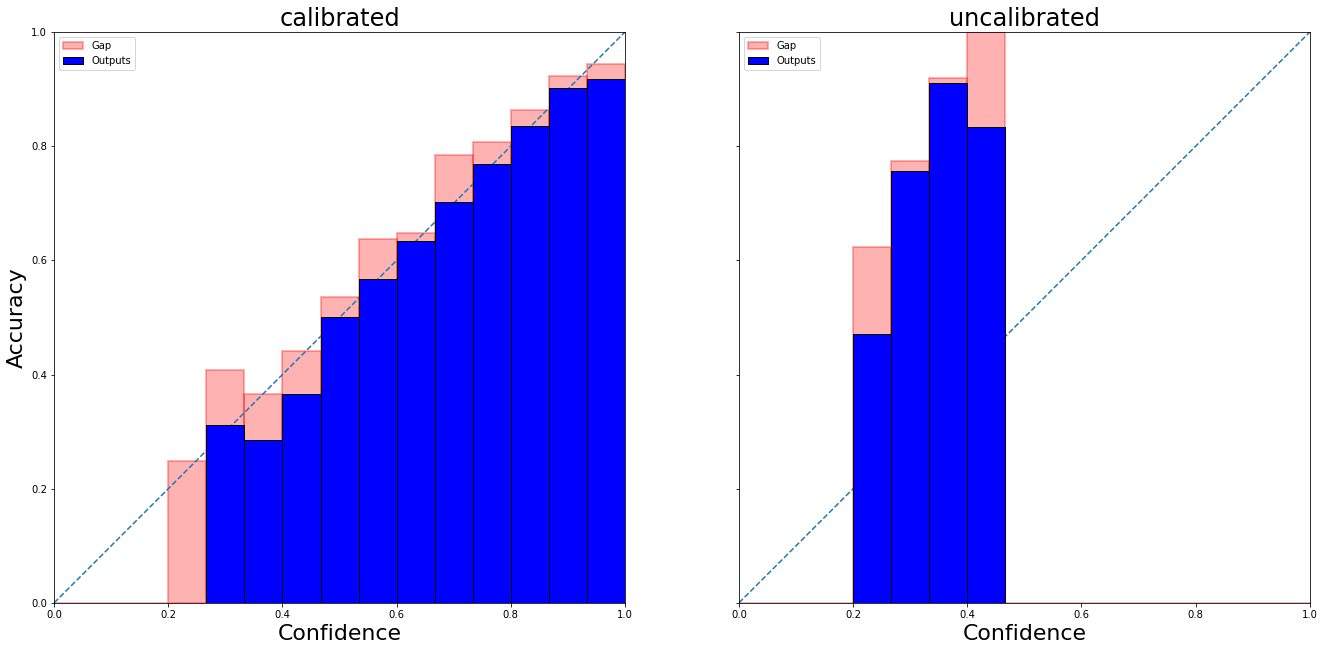

In [63]:
from cal_methods import HistogramBinning, TemperatureScaling, softmax
from evaluation import get_bin_info

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import copy 
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

# fig = plt.figure(0, figsize=(10, 10))
# ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
# ax2 = plt.subplot2grid((3, 1), (2, 0))     
# ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
logits_train=model.predict(train_x)
logits_test=model.predict(test_x)
train_y=target_train
test_y=target_test
                        
# prob_pos =(prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
# classSelected=3
tempTarget=copy.copy(train_y)

# tempTarget[tempTarget==classSelected]=-1
# tempTarget[tempTarget!=-1]=0
# tempTarget[tempTarget==-1]=1

M = 15
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22.5, 12), sharex='col', sharey='row')
accs_confs=cal_res(IsotonicRegression,logits_train, train_y, logits_test, test_y, M, "", "single", {'y_min':0, 'y_max':1})
bin_info_uncal=get_uncalibrated_res(logits_train, train_y, logits_test, test_y, M)
confUncalib=np.asarray(bin_info_uncal[1])
confUncalib =(confUncalib - confUncalib.min()) / (confUncalib.max() - confUncalib.min())
k=1

rel_diagram_sub(accs_confs[k][0], accs_confs[k][1], ax[0] , M = M, name = "calibrated", xname="Confidence")
rel_diagram_sub(bin_info_uncal[0], confUncalib, ax[1] , M = M, name = "uncalibrated", xname="Confidence")
ax[0].set_ylabel("Accuracy", color = "black")
fig.savefig('calibrated_1.png', dpi=100)
# clf_score = brier_score_loss(tempTarget, prob_pos, pos_label=out.max())
# fraction_of_positives, mean_predicted_value = calibration_curve(tempTarget, prob_pos, n_bins=10)
# name='proposed_method'
# ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
#             label="%s (%1.3f)" % (name, clf_score))

# ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
#             histtype="step", lw=2)

# ax1.set_ylabel("Fraction of positives")
# ax1.set_ylim([-0.05, 1.05])
# ax1.legend(loc="lower right")
# ax1.set_title('Calibration plots  (reliability curve)')

# ax2.set_xlabel("Mean predicted value")
# ax2.set_ylabel("Count")
# ax2.legend(loc="upper center", ncol=2)

In [64]:
confUncalib

array([0.        , 0.        , 0.        , 0.62284824, 0.75578279,
       0.91040531, 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [37]:
%autoreload
from cal_methods import HistogramBinning, TemperatureScaling, evaluate, cal_results


train_y=target_train.astype(int)
test_y=target_test.astype(int)
# train_y=to_categorical(target_train)
# test_y=to_categorical(target_test)

# classSelected=1
# tempTarget=copy.copy(train_y)
# tempTarget[tempTarget==classSelected]=-1
# tempTarget[tempTarget!=-1]=0
# tempTarget[tempTarget==-1]=1

# tempTargetTest=copy.copy(test_y)
# tempTargetTest[tempTargetTest==classSelected]=-1
# tempTargetTest[tempTargetTest!=-1]=0
# tempTargetTest[tempTargetTest==-1]=1

df_iso = cal_results(IsotonicRegression,logits_train, train_y, logits_test, test_y,approach="single")

Accuracy: 66.03999999999999
Error: 33.96000000000001
ECE: 0.3843016343633334
MCE: 0.5411563479527831
Loss: 1.3876290003736813
brier: 74633.57684943368
Error 29.850000; ece 0.055573; mce 0.175192; loss 0.871810, brier 39834.459924
Time taken: 2.709414482116699 



array([[0.38465804, 0.27350694, 0.22322933, 0.0376973 , 0.08090832],
       [0.01544158, 0.20065528, 0.08632301, 0.01172984, 0.68585026],
       [0.03474379, 0.08101748, 0.08390561, 0.77889067, 0.02144249],
       ...,
       [0.42284444, 0.00607491, 0.17028405, 0.38967738, 0.01111931],
       [0.4647214 , 0.1316995 , 0.21773542, 0.12043111, 0.06541251],
       [0.04138501, 0.00503986, 0.0557928 , 0.8932334 , 0.00454888]],
      dtype=float32)